In [ ]:
!pip install vosk


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 18.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 9.0 MB/s eta 0:00:00
  Created wheel for srt: filename=srt-3.5.3-py3-none-any.whl size=22428 sha256=231666d7349f86a2d6e1407c0a8f7453160fb7ac51b69ac9a5acd2618c7cdc8f
  Stored in directory: /root/.cache/pip/wheels/d7/31/a1/18e1e7e8bfdafd19e6803d7eb919b563dd11de380e4304e332
Successfully built srt


In [ ]:
!pip install librosa


In [ ]:
!pip install torchaudio

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [ ]:
!pip install torchvision

In [ ]:
!apt-get install ffmpeg


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [ ]:
import os
def extract_audio(video_path, audio_path):
    # Run ffmpeg command to extract audio
    os.system(f"ffmpeg -i {video_path} -vn -acodec pcm_s16le -ar 44100 -ac 1 {audio_path}")

# Define paths to your video folders
folder1_path = "/content/hate_videos"
folder2_path = "/content/non_hate_videos"

# Define output folder paths for audio files
output_folder1_path = "/content/output_hate"
output_folder2_path = "/content/output_non_hate"

# Create output folders if they don't exist
os.makedirs(output_folder1_path, exist_ok=True)
os.makedirs(output_folder2_path, exist_ok=True)

# Iterate over files in folder 1
for filename in os.listdir(folder1_path):
    if filename.endswith(".mp4"):
        video_path = os.path.join(folder1_path, filename)
        audio_path = os.path.join(output_folder1_path, filename.replace(".mp4", ".wav"))
        extract_audio(video_path, audio_path)

# Iterate over files in folder 2
for filename in os.listdir(folder2_path):
    if filename.endswith(".mp4"):
        video_path = os.path.join(folder2_path, filename)
        audio_path = os.path.join(output_folder2_path, filename.replace(".mp4", ".wav"))
        extract_audio(video_path, audio_path)

In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import preprocess_input
import numpy as np
import os
import librosa
from skimage.transform import resize

# Load pre-trained VGG-19 model
base_model = VGG19(weights='imagenet', include_top=True)

# # Define a new model that includes only the convolutional base of VGG19
# model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc2').output)

# Function to load and preprocess audio spectrogram
def load_and_preprocess_spectrogram(audio_path, sr=22050, n_mels=128, hop_length=512, duration=10, target_shape=(224, 224)):
    # Load audio file
    audio, sr = librosa.load(audio_path, sr=sr, duration=duration, mono=True)

    # Generate mel spectrogram
    spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels, hop_length=hop_length)

    # Convert to decibel-scale spectrogram (log-magnitude)
    spectrogram = librosa.power_to_db(spectrogram, ref=np.max)

    # Resize the spectrogram to the target shape
    spectrogram = resize(spectrogram, target_shape, anti_aliasing=True)

    # Expand dimensions to make it compatible with VGG-19 input shape
    spectrogram = np.expand_dims(spectrogram, axis=-1)
    spectrogram = np.repeat(spectrogram, 3, axis=-1)  # Duplicate to create three channels

    # Preprocess the spectrogram for VGG-19 model
    spectrogram = preprocess_input(spectrogram)

    return spectrogram

# Function to extract features from audio spectrograms using VGG-19 model
def extract_audio_features(audio_folder):
    features = []
    for filename in os.listdir(audio_folder):
        if filename.endswith(".wav"):
            audio_path = os.path.join(audio_folder, filename)
            # Load and preprocess audio spectrogram
            spectrogram = load_and_preprocess_spectrogram(audio_path)
            # Extract features using VGG-19 model
            audio_features = base_model.predict(np.expand_dims(spectrogram, axis=0))
            # Flatten the features
            audio_features = audio_features.flatten()
            features.append(audio_features)
    return np.array(features)

# Extract features for hate audio files
hate_audio_folder = "/content/output_hate"
hate_features = extract_audio_features(hate_audio_folder)

# Extract features for non-hate audio files
non_hate_audio_folder = "/content/output_non_hate"
non_hate_features = extract_audio_features(non_hate_audio_folder)


1/1 [==============================] - 1s 752ms/step


In [ ]:
# Function to extract features from audio spectrograms using VGG-19 model and apply PCA
from sklearn.decomposition import PCA

def extract_audio_features_with_pca(audio_folder, n_components=330):
    features = []
    for filename in os.listdir(audio_folder):
        if filename.endswith(".wav"):
            audio_path = os.path.join(audio_folder, filename)
            # Load and preprocess audio spectrogram
            spectrogram = load_and_preprocess_spectrogram(audio_path)
            # Extract features using VGG-19 model
            audio_features = base_model.predict(np.expand_dims(spectrogram, axis=0))
            # Flatten the features
            audio_features = audio_features.flatten()
            features.append(audio_features)
    # Convert features to numpy array
    features = np.array(features)
    # Apply PCA
    pca = PCA(n_components=n_components)
    features_pca = pca.fit_transform(features)
    return features_pca
# Extract features for hate audio files with PCA
hate_features_pca = extract_audio_features_with_pca(hate_audio_folder)

# Extract features for non-hate audio files with PCA
non_hate_features_pca = extract_audio_features_with_pca(non_hate_audio_folder)


1/1 [==============================] - 1s 756ms/step


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-3)


# Define the neural network architecture
model = Sequential([
    Dense(128, activation='relu', input_shape=(1000,)),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
# Assuming hate_features and non_hate_features are the feature vectors for hate and non-hate audio files
# hate_labels and non_hate_labels are the corresponding labels (1 for hate, 0 for non-hate)
features = np.concatenate((hate_features, non_hate_features), axis=0)
labels = np.concatenate((np.ones(len(hate_features)), np.zeros(len(non_hate_features))), axis=0)
history = model.fit(features, labels, epochs=90, batch_size=64, validation_split=0.2, callbacks=[reduce_lr])



Epoch 1/90
9/9 [==============================] - 1s 30ms/step - loss: 0.6842 - accuracy: 0.6082 - val_loss: 0.7948 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/90
9/9 [==============================] - 0s 9ms/step - loss: 0.6622 - accuracy: 0.6231 - val_loss: 0.9880 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/90
9/9 [==============================] - 0s 10ms/step - loss: 0.6517 - accuracy: 0.6231 - val_loss: 1.0194 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 4/90
9/9 [==============================] - 0s 11ms/step - loss: 0.6450 - accuracy: 0.6231 - val_loss: 0.9961 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 5/90
9/9 [==============================] - 0s 9ms/step - loss: 0.6388 - accuracy: 0.6231 - val_loss: 0.9373 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 6/90
9/9 [==============================] - 0s 13ms/step - loss: 0.6341 - accuracy: 0.6231 - val_loss: 0.9498 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 7/90
9/9 [==============================] - 0s 10ms/step - l

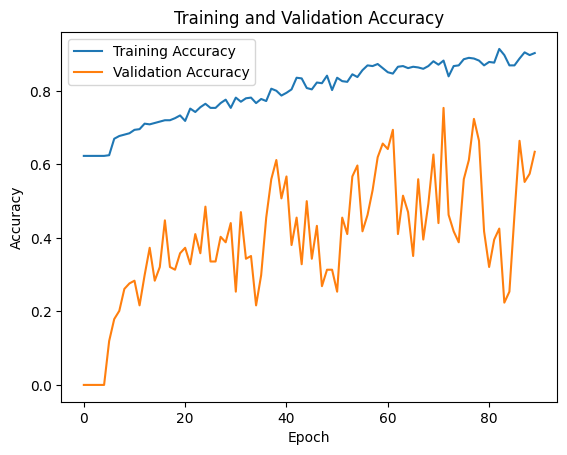

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score

# Evaluate the model
loss, accuracy = model.evaluate(features, labels, verbose=0)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Predict classes
predictions = (model.predict(features) > 0.5).astype("int32")

# Calculate validation accuracy
val_accuracy = accuracy_score(labels, predictions)
print("Validation Accuracy:", val_accuracy)

# Calculate recall
recall = recall_score(labels, predictions)
print("Recall:", recall)

# Calculate confusion matrix
cm = confusion_matrix(labels, predictions)
print("Confusion Matrix:")
print(cm)


Test Loss: 0.4618041515350342
Test Accuracy: 0.8343283534049988
21/21 [==============================] - 0s 2ms/step
Validation Accuracy: 0.8343283582089552
Recall: 0.9580838323353293
Confusion Matrix:
[[239  97]
 [ 14 320]]
